In [60]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import scipy as sp


In [72]:
class SCRAMTarget:
    def __init__(self,densLayers,tempLayers,j_f,k_f,fh,fj,en_VH,en_HR,dx=0.5e-4):
        self.densLayers = densLayers
        self.tempLayers = tempLayers
        self.k_f = k_f
        self.j_f = j_f
        self.fh = fh
        self.fj = fj
        self.en_VH = en_VH
        self.en_HR = en_HR
        self.dx = dx
        self.layers = []
        self.generateLayers()

    '''
    Calculating j and k for each layer with density 'dens' and temperature 'temp'
    '''
    def generateLayers(self):
        self.layers = []
        for dens, temp in zip(self.densLayers, self.tempLayers):
            
            #generate front layers using VH energy axis
            k_layer_fluor_f = (np.log(dens),np.log(temp),np.log(self.en_VH))
            k_layer_fluor_f = self.k_f(k_layer_fluor_f)
            k_layer_fluor_f = np.exp(k_layer_fluor_f)
            j_layer_fluor_f = (np.log(dens),np.log(temp),np.log(self.en_VH))
            j_layer_fluor_f = self.j_f(j_layer_fluor_f)
            j_layer_fluor_f = np.exp(j_layer_fluor_f)
            
            
            #generate rear layers using HR energy axis
            k_layer_fluor_r = (np.log(dens),np.log(temp),np.log(self.en_HR))
            k_layer_fluor_r = self.k_f(k_layer_fluor_r)
            k_layer_fluor_r = np.exp(k_layer_fluor_r)
            j_layer_fluor_r = (np.log(dens),np.log(temp),np.log(self.en_HR))
            j_layer_fluor_r = self.j_f(j_layer_fluor_r)
            j_layer_fluor_r = np.exp(j_layer_fluor_r)

            k_layer_f = k_layer_fluor_f
            j_layer_f = j_layer_fluor_f

            k_layer_r = k_layer_fluor_r
            j_layer_r = j_layer_fluor_r
            
            self.layers.append([dens, temp, k_layer_f, j_layer_f,k_layer_r,j_layer_r,j_layer_fluor_f,j_layer_fluor_r])
    
    '''Determines the fraction of hot electrons with energy greater than 80% of the K-shell'''
    def f_greater(self,Th):
        return min(1,2/np.sqrt(np.pi)*np.exp(-0.72*10.285/Th)) 
   
    '''
    Calculates the scaling of the fluorescence emission for a particular hot electron
    fraction and electron temperature
    '''
    def scale_fluor(self,D,Te,hotfrac,Th):
        fh_tab = self.fh((D,Te))
        fj_bin = np.exp(self.fj((np.log(D),np.log(Te))))
        scaling = fj_bin*self.f_greater(Th)*hotfrac/(0.8*fh_tab)
        return scaling 
   
    '''
    Transmission through layer defined by opitcal depth T = exp(-k*dx) where k 
    is the absorbtion coefficient in 1/cm and dx is the plasma depth in cm

    The projection is required if non-normal path lengths are used, such as the
    von Hamos spectra acquired at 45 deg from normal
    '''
    def getTransmission(self,layer,projection,rear):
        #exp(-k_rear*dx) - using indices from self.layers
        if rear: 
          return np.exp(-layer[4]*self.dx*projection)
        #exp(-k_front*dx) - using indices from self.layers
        else:
          return np.exp(-layer[2]*self.dx*projection)

    def transportEmission(self,fh,Th,viewingAngle = 0,rear = False):
        '''
        Performs radiation transport through individual layers to a detector at specified
        viewing angle and on the front or rear side of the target.
        '''
        projection = 1./np.cos(np.radians(viewingAngle))
        intensityTotal = 0
        trans_layers = [self.getTransmission(layer,projection,rear) for layer in self.layers]
        '''
        Self-emission intensity is defined by I = j/k(1-T)
        Total intensity is calculated by starting at either end of the target 
        (if the detector is on the rear side it begins with the front and vice verse)
        and sequentially stepping through individual layers calculating self-emission 
        intensity and transmission

        Stephanie Hansen recommends that we don't want to double count the flourescence contribution
        from a hot plasma region. Therefore, we should ignore the flourescence emission as the K-alpha line
        begins to shift from the cold plasma. Looking at the j emission, significant shifting appears to 
        occur by 500 eV, so I'll cut it there.
        '''
        for i,layer in enumerate(self.layers):
            #tranmission to High Resolution Crystal
            if rear:
                intensity_layer = (layer[5])/layer[4]*(1-trans_layers[i])
                transmission = np.prod(trans_layers[i+1:],axis = 0)

            #transmission to Von Hamos crystal
            else:
                intensity_layer = (layer[3]+layer[6]*self.scale_fluor(layer[0],layer[1],fh,Th)*100)/layer[2]*(1-trans_layers[i])
                transmission = np.prod(trans_layers[:i],axis = 0) 
            intensityTotal += intensity_layer*transmission

        return intensityTotal


    def model(self,d,t,fh,Th):
        #initialize with new temps
        self.densLayers = d
        self.tempLayers = t
        self.generateLayers()
        
        #Assume 5um Spot Size, 1ps Emission Time
        area = np.pi*(2.5e-4)**2
        tau = 1e-12
        scaling = area*tau/(np.pi/4000) #pi/4000 = 1e-3/4*pi converts to mj/keV/sr
        sigma = 8/(2*np.sqrt(2*np.log(2))) 

        #Front Von Hamos Spectra
        front_emission = self.transportEmission(fh,Th,45,rear=False)
        SimulatedVH = sp.ndimage.gaussian_filter1d(front_emission*scaling*1000,sigma)                                            

        #Rear High Res. Spectra
        rear_emission = self.transportEmission(fh,Th,0,rear=True)
        SimulatedHR = sp.ndimage.gaussian_filter1d(rear_emission*scaling*1000,sigma/8)                   

        return SimulatedVH, SimulatedHR

In [62]:
def get_interp():
    df = pd.read_csv(f'C:\\Users\\Matth\\OneDrive\\Desktop\\LowTempScram\\2020_LaserNetCSUCombinedData\\SCRAM\\SCRAMlow.txt',delimiter = '\t')
    densities = df.iloc[[0], :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float)
    densities.columns = range(densities.shape[1])
    temperatures = df.iloc[[1], :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float) / 1000
    temperatures.columns = range(temperatures.shape[1])
    mdet = df.iloc[[2], :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float)
    mdet.columns = range(mdet.shape[1])
    KPfac1 = df.iloc[[21], :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float)
    KPfac1.columns = range(KPfac1.shape[1])

    info = pd.concat([densities,temperatures,mdet,KPfac1],ignore_index=1)
    
    
    j_values = df.iloc[23:3356, :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float)
    j_values.columns = range(j_values.shape[1])
    k_values = df.iloc[3357:, :].reset_index(drop=True).drop(columns=df.columns[0]).astype(float)
    k_values.columns = range(k_values.shape[1])
    denuinque = np.unique(info.iloc[0,:])
    tempunique = np.unique(info.iloc[1,:])
    j_fluor = np.zeros((len(denuinque), len(tempunique), len(j_values))) 
    k_fluor = np.zeros((len(denuinque), len(tempunique), len(k_values)))
    hot_electron_fraction = np.zeros((len(denuinque), len(tempunique))) 
    factor_fluor = np.zeros((len(denuinque), len(tempunique))) 
   
    for ix,d in enumerate(denuinque):
        for jx,t  in enumerate(tempunique):
            for mx in range(len(densities.to_numpy()[0])):
                if d == densities.to_numpy()[0][mx] and t == temperatures.to_numpy()[0][mx]:
                    j_fluor[ix][jx] = j_values.to_numpy()[:,mx]
                    k_fluor[ix][jx] = k_values.to_numpy()[:,mx]
                    hot_electron_fraction[ix][jx] = mdet.to_numpy()[0][mx]
                    factor_fluor[ix][jx] = KPfac1.to_numpy()[0][mx]
    en_j = df.iloc[23:3356, :].reset_index(drop=True).iloc[:,0].astype(float) / 1000
    en_k = df.iloc[3357:, :].reset_index(drop=True).iloc[:,0].astype(float) / 1000

    l_dens = np.log(denuinque)
    l_Te = np.log(tempunique)
    l_en_j = np.array(np.log(en_j))
    log_j_fluor = np.log(j_fluor)
    log_k_fluor = np.log(k_fluor)
    l_en_k = np.array(np.log(en_k))


    j_fluor_interp = sp.interpolate.RegularGridInterpolator((l_dens,l_Te,l_en_j),log_j_fluor) 
    k_fluor_interp = sp.interpolate.RegularGridInterpolator((l_dens,l_Te,l_en_k),log_k_fluor) 
    hot_electron_interp =  sp.interpolate.RegularGridInterpolator((denuinque,tempunique),hot_electron_fraction,bounds_error = False) 
    factor_fluor_interp =  sp.interpolate.RegularGridInterpolator((l_dens,l_Te),np.log(factor_fluor)) 
    return j_fluor_interp, k_fluor_interp, hot_electron_interp,factor_fluor_interp





In [63]:
j_f,k_f,fh,fj = get_interp()

In [64]:
base_path = Path.cwd().resolve()
print(base_path)
data_dir = "2020_LaserNetCSUCombinedData"
os.chdir(f'{base_path}')
os.chdir(base_path)

C:\Users\Matth\OneDrive\Desktop\LowTempScram\2020_LaserNetCSUCombinedData\SCRAM\Code


In [77]:
#Define energy axes, density layers, and temp layers


def plotter(dens, temp, flor, err,dx=0.5e-4, dens2=3, temp2=3, flor2=0.003, err2=0, dx2 = 0.5e-4, ploton=False, compare = False):
    en_VH = np.linspace(8,9.97,2995) #Spectral range of front side von Hamos spectrometer
    en_HR = np.linspace(8,8.45,2995) #Spectral range of rear side spherical crystal spectrometer
    dens = [dens] #Solid Density copper LOW BoUND: 2.23; HIGH BOUND 18.00
    temp = [temp] #Reasonable temperature of 3.5 keV #LOW BOUND 0.10; HIGH BOUND 6.40
    dens2 = [dens2]
    temp2 = [temp2]
     #Single layer of thickness 500 nm

    #get interpolators for j,k, and fluorescence

    j_f,k_f,fh,fj = get_interp() #Extracts j, k from SCRAM

    target1 = SCRAMTarget(dens,temp,j_f,k_f,fh,fj,en_VH,en_HR,dx) #Generates class object with the specified parameters
    target2 = SCRAMTarget(dens2,temp2,j_f,k_f,fh,fj,en_VH,en_HR,dx2)
    #generating test spectra with noise
    #target = SCRAMTarget(dens,temp,j,k,en_VH,en_HR,dx)
    test_VH, test_HR = target1.model(dens,temp,flor,100)
    test_VH2, test_HR2 = target2.model(dens2,temp2,flor2,100)
    baselineVH,baselineHR = np.zeros((0, 2995)),np.zeros((0, 2995))
    error = err #controls how noisy the spectra are
    error2 = err2
    noise_VH = np.random.normal(0,error*np.std(test_VH),en_VH.shape)
    noise_HR = np.random.normal(0,error*np.std(test_HR),en_HR.shape)
    
    noise_VH2 = np.random.normal(0,error2*np.std(test_VH2),en_VH.shape)
    noise_HR2 = np.random.normal(0,error2*np.std(test_HR2),en_HR.shape)
    
    if ploton == True:
        fig, axs = plt.subplots(nrows = 2, ncols = 1)
        fig.set_figwidth(10)
        fig.set_figheight(8)
        fig.tight_layout(pad = 4)
        fig.suptitle('Simulated Spectra with Gaussian Noise')

        axs[0].plot(en_VH,test_VH+noise_VH, label = 'Simulated')
        axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[0].set(xlabel = 'Photon Energy [keV]')
        
        axs[1].plot(en_HR,test_HR+noise_HR)
        axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
        axs[1].set(xlabel = 'Photon Energy [keV]');
        
        if compare == True:
            axs[0].plot(en_VH,test_VH2+noise_VH2, label = 'Predicted', linestyle = '--')
            axs[0].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[0].set(xlabel = 'Photon Energy [keV]')
            axs[0].legend()

            axs[1].plot(en_HR,test_HR2+noise_HR2, linestyle = '--')
            axs[1].set(ylabel = r'Intensity $\frac{mJ}{keV\cdot sr}$')
            axs[1].set(xlabel = 'Photon Energy [keV]');
            axs[1].legend()
        colors = np.random.rand(3,3)
        axs[0].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[0].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[0].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[0].axvspan(8.62,8.72,alpha=0.3,color=(0.3,0.5,0.7),label =r'$Ly \alpha$')
        axs[0].axvspan(8.87,8.92,alpha=0.3,color=(0.4,0.4,0.8),label =r'$K \beta$')
        axs[0].axvspan(9.72,9.9,alpha=0.3,color=(0.7,0.7,0.9),label =r'$He \beta$')
        axs[0].legend()

        axs[1].axvspan(8.01,8.07,alpha=0.3,color=(0.1,0.9,0.1),label =r'$K \alpha$')
        axs[1].axvspan(8.17,8.31,alpha=0.3,color=(.1,0.70,0.400),label =r'$Li-Like$')
        axs[1].axvspan(8.31,8.42,alpha=0.3,color=(0.1,0.60,0.6),label =r'$He \alpha$')
        axs[1].legend()
    intensity1 = []
    intensity2 = []
    intensity1.append(test_VH+noise_VH)
    intensity2.append(test_HR+noise_HR)

    energy_intensity_dfVH = pd.concat([pd.DataFrame(en_VH.reshape(1,-1)),pd.DataFrame(intensity1)])
    energy_intensity_dfHR = pd.concat([pd.DataFrame(en_HR.reshape(1,-1)),pd.DataFrame(intensity2)])
    return energy_intensity_dfVH, energy_intensity_dfHR


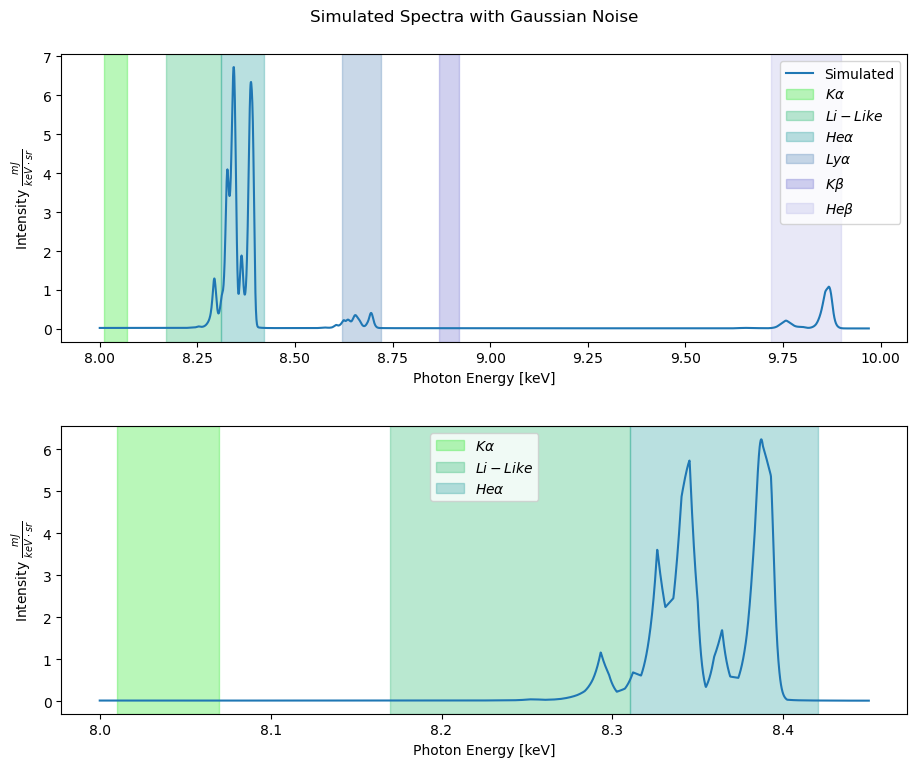

In [80]:
x,x = plotter(4,3,1e-3,0,ploton=True)